# Converting XT matrix to XZ (2D)

### Load the files

In [4]:
import numpy as np
import scipy.fft
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
by = np.load('./npy_files/By.npy')
x = np.load('./npy_files/x.npy')
#y = np.load('./npy_files/y.npy')
t = np.load('./npy_files/t.npy')

In [ ]:
if False:
    XPOINTS = 200
    TPOINTS = 1500
    XMAX = 10
    TMAX = 10
    lmb = 1
    Z = -21
    r = np.linspace(-XMAX, XMAX, XPOINTS, dtype="float64")
    t = np.linspace(-TMAX + Z, TMAX + Z, TPOINTS, dtype="float64")
    tau = 4
    T, R = np.meshgrid(t, r)
    E0 = 1
    w0 = 2. * lmb
    ZR = np.pi * w0**2 / lmb
    k = 2*np.pi/lmb
    wz = w0*np.sqrt(1+(Z / ZR)**2)
    one_over_Rz = Z / (Z**2 + ZR**2)
    curvature = one_over_Rz*k*R**2/2
    phiz = np.arctan(Z / ZR)
    byt = E0*w0/wz*np.exp(-R**2/wz**2) * np.exp(-1j * (k * (Z - T) + curvature - phiz))
    byt = byt*np.exp(-((Z - T)/tau)**2)
    byt = np.real(byt)
    clim = np.max(np.abs(byt))
    fig, ax = plt.subplots(figsize = [8,6])
    extent = [-TMAX + Z, TMAX + Z, -XMAX, XMAX]
    ax.imshow(byt, cmap="seismic", clim = [-clim, clim], aspect = 'equal', extent = extent)
    # 3D
    by = np.zeros((3,) + byt.shape)
    by[1] = byt
    x = r

#### Restrict to XT (2D)

In [ ]:
by = by[by.shape[0]//2,:,:]
plt.pcolormesh(t, x, by, shading="auto")

#### Build FFT and freq grids

In [10]:
def build_fft(x, t, by):
    # Apply discrete fourier transform
    
    print("Allocating array %sx%s..." % by.shape, end="", flush=True)
    byfft = np.asarray(by, dtype="complex64")
    print("OK")
    
    # FW
    
    print("Applying discrete fast fourier transform...", end="", flush=True)
    byfft = scipy.fft.fftn(byfft,
                           axes=(0,1),
                           norm="forward",
                           overwrite_x=True)
    print("OK")
    
    print("Building freq grid...", end="", flush=True)
    # Build frequences grid
    freqx = np.fft.fftfreq(x.size, d=x[1] - x[0])
    freqt = np.fft.fftfreq(t.size, d=t[1] - t[0])

    KX, W = np.meshgrid(freqx, freqt, indexing='ij')
    print("OK")
    return KX, W, byfft

In [ ]:
KX, W, byfft = build_fft(x, t, by)

#### Build propagation vector

In [ ]:
# aW = abs(W)
# Wi, Wni = (aW > 0.01), (aW <= 0.01)

KZ2 = (W**2 - KX**2)  # On suppose KY = 0 en 2D...
KZ2[KZ2 < 0] = 0.
KZ = np.sqrt(KZ2)

# KZ = np.zeros(W.shape)
# KZ[Wi] = W[Wi]*(1-0.5*(KX[Wi]**2)/W[Wi]**2)
# byfft[Wni] = 0.

In [ ]:
Z_LENGTH = 1000
TOT_Z = (t[0] - t[-1])
Z_OFFSET = 0
dz = TOT_Z / Z_LENGTH

In [ ]:
# Apply offset
if Z_OFFSET:
    propag_offset = np.exp(np.pi * 2j * KZ * Z_OFFSET)
    propag_offset[W<0] = 0.
    byfft *= propag_offset
    del propag_offset

In [ ]:
# Build propag vector

# propag = np.zeros(KX.shape, dtype="complex128")
# propag[Wi] = np.exp(-np.pi * 1j * (KX[Wi]**2) / W[Wi] * dz)

propag = np.exp(np.pi * 2j * KZ * dz)
propag[W<0] = 0.

#### Setup display libraries

In [ ]:
ENABLE_ANIMATION = False

#if Z_LENGTH != t.shape[0]:
#    ENABLE_ANIMATION = False
#    print("Animation disabled because Z_LENGTH := t.shape[0]")

if ENABLE_ANIMATION:
    import matplotlib.pyplot as plt
    import numpy as np
    from celluloid import Camera
    from IPython.display import HTML

#### Propagate to create XT matrix

In [ ]:
plt.rcParams['figure.figsize'] = [11, 7]
plt.rcParams['figure.dpi'] = 50

if ENABLE_ANIMATION:
    fig = plt.figure()
    camera = Camera(fig)

frame = np.empty(byfft.shape[:1] + (Z_LENGTH,))
for i in tqdm(range(Z_LENGTH)):
    byfft = byfft * propag
    v = scipy.fft.ifftn(byfft,
                        axes=(0,1),
                        norm="forward")
    if ENABLE_ANIMATION and i % 10 == 0:
        # z = np.arange(-abs(dz) * i, (Z_LENGTH - i) * abs(dz), abs(dz))
        plt.pcolormesh(np.real(v), shading="auto")
        camera.snap()
    frame[:,i] = np.real(v)[:,0]

if ENABLE_ANIMATION:
    animation = camera.animate()
    res = HTML(animation.to_html5_video())
else:
    res = None

res

In [ ]:
z = np.linspace(TOT_Z, 0, frame.shape[1])
clim = np.max(np.abs(frame))
plt.pcolormesh(z, x, frame, shading="auto", cmap="seismic", vmin=-clim, vmax=clim)

# Propagate along the T axis

In [62]:
import numpy as np
import scipy.fft
from tqdm import tqdm
import matplotlib.pyplot as plt

# T_MODE = "reuse"
# T_MODE = "generate"
T_MODE = "read"

#### Generate 1: Re-use data from Z to T or use debug gaussian beam

In [63]:
if T_MODE == "generate":
    XLENGTH = 200
    ZLENGTH = 800
    XMAX = 200
    ZMAX = 400
    TOT_Z = -ZLENGTH
    dz = 1
    x = np.linspace(-XMAX, XMAX, XLENGTH, dtype="float64")
    z = np.linspace(-ZMAX, ZMAX, ZLENGTH, dtype="float64")
    r = np.abs(x)
    Z, R = np.meshgrid(z, r)
    Z[Z==0.] = 0.01
    lmb = 3*1e8 * 1e-7
    E0 = 1
    w0 = 20
    print(w0/lmb)
    n = 1.2
    ZR = np.pi*w0**2*n/lmb
    k = 2*np.pi*n/lmb
    wz = w0*np.sqrt(1+(Z / ZR)**2)
    Rz = Z*(1+(ZR/Z)**2)
    phiz = np.arctan(Z / ZR)
    byz = E0*w0/wz*np.exp(-R**2/wz**2)*np.exp(-1j*(k*Z+k*R**2/(2*Rz)-phiz))
    byz = byz*np.exp(-np.abs(Z**2)/10000)
    frame = np.real(byz)
    clim = np.max(np.abs(frame))
    plt.rcParams['figure.figsize'] = [10, 7]
    plt.rcParams['figure.dpi'] = 200
    plt.pcolormesh(frame, shading="auto", cmap="seismic", vmin=-clim, vmax=clim)

if T_MODE in ["generate", "reuse"]:
    z = np.arange(TOT_Z, 0, abs(dz))

#### Generate 2: (Alternative) - Read XYZ matrix

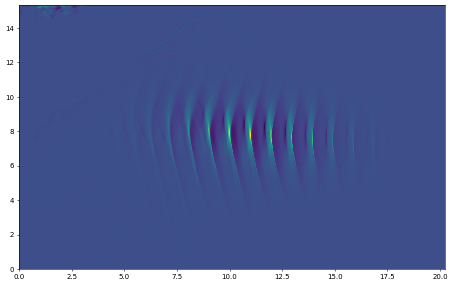

In [64]:
if T_MODE == "read":
    by = np.load('./npy_files/By_xyz.npy')
    z = np.linspace(0, 2072/102.4, 2072)
    y = np.linspace(0, 1500/102.4, 1500)
    x = np.linspace(0, 1450/94.5231, 1450)
    frame = by[:,by.shape[1]//2,:].transpose(1, 0)
    plt.pcolormesh(z, x, frame, shading="auto")

#### Config

In [65]:
dt = -0.4
OFFSET = 10
MAX_INSTANT = 100

#### Perform FFT

In [66]:
def build_fft(x, t, by):
    # Apply discrete fourier transform
    
    print("Allocating array %sx%s..." % by.shape, end="", flush=True)
    byfft = np.asarray(by, dtype="complex64")
    print("OK")
    
    # FW
    
    print("Applying discrete fast fourier transform...", end="", flush=True)
    byfft = scipy.fft.fftn(byfft,
                           axes=(0,1),
                           norm="forward",
                           overwrite_x=True)
    print("OK")
    
    print("Building freq grid...", end="", flush=True)
    # Build frequences grid
    freqx = np.fft.fftfreq(x.size, d=x[1] - x[0])
    freqt = np.fft.fftfreq(t.size, d=t[1] - t[0])

    KX, W = np.meshgrid(freqx, freqt, indexing='ij')
    print("OK")
    return KX, W, byfft

In [67]:
KX, KZ, byfft = build_fft(x, z, frame)

Allocating array 1450x2072...OK
Applying discrete fast fourier transform...OK
Building freq grid...OK


#### Build propag vector

In [68]:
W = np.sqrt(KX**2 + KZ**2)
Wni = np.abs(W) < 0.5

propag = np.exp(np.pi * 2j * (W - KZ) * dt)
propag[KZ < 0] = 0.
propag[Wni] = 0.

#### Offset

In [69]:
propag_offset = np.exp(np.pi * 2j * (W - KZ) * OFFSET)
propag_offset[KZ < 0] = 0.
propag_offset[Wni] = 0.
byfft *= propag_offset
del propag_offset

#### Propagate on t and display

In [70]:
import matplotlib.pyplot as plt
import numpy as np
from celluloid import Camera
from IPython.display import HTML

100%|██████████| 100/100 [00:49<00:00,  2.03it/s]


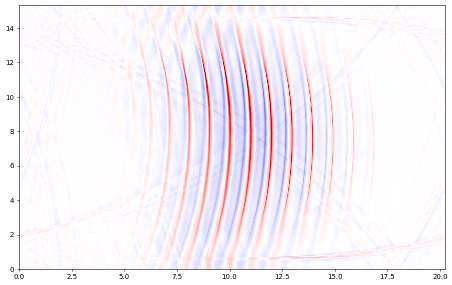

In [71]:
plt.rcParams['figure.figsize'] = [11, 7]
plt.rcParams['figure.dpi'] = 50

fig = plt.figure()
camera = Camera(fig)

EVERY = 1

clim = None
# First propagate on z
for i in tqdm(range(MAX_INSTANT)):
    byfft *= propag
    v = scipy.fft.ifftn(byfft,
                        axes=(0,1),
                        norm="forward")
    if clim is None:
        clim = np.max(np.abs(v))
    if i % EVERY == 0:
        # Display image
        plt.pcolormesh(z, x, np.real(v), shading="auto", cmap="seismic", vmin=-clim, vmax=clim)
        camera.snap()
    del v

animation = camera.animate()
HTML(animation.to_html5_video())